In [1]:
# https://www.youtube.com/watch?v=q_HS4s1L8UI

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 

import torch
import torch.nn as nn

data = pd.read_csv("C:/Users/trist/Downloads/AMZN.csv")



In [4]:
data = data[["Date", "Close"]]

C:\Users\trist\AppData\Local\Temp\ipykernel_9912\2293186012.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data["Date"])


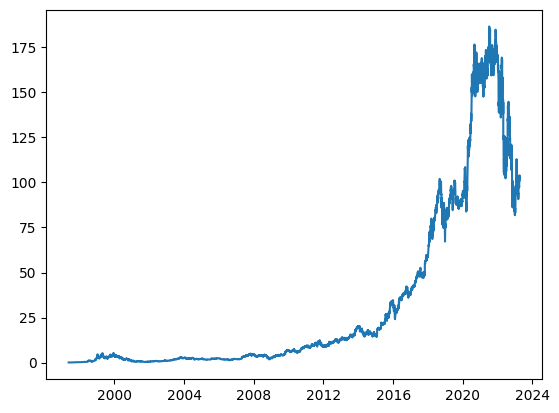

In [6]:
data['Date'] = pd.to_datetime(data["Date"])
plt.plot(data["Date"], data['Close'])

In [8]:
from copy import deepcopy as dc
def prepare_df(df, n_steps):
    df = dc(df)
    df.set_index('Date', inplace = True)
    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)
    
    df.dropna(inplace=True)

    return df

lookback = 5
shifted_df = prepare_df(data, lookback)
shifted_df.head()

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5)
Date,,,,,,
1997-05-22,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
1997-05-23,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458
1997-05-27,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417
1997-05-28,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771
1997-05-29,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354


In [9]:
shifted_df_np = shifted_df.to_numpy()

In [10]:
# The MinMaxScaler from the sklearn.preprocessing module is commonly used in 
# machine learning to scale numerical features in a dataset to a specific range, 
# usually between 0 and 1. Scaling is an important preprocessing step in machine 
# learning because it can help improve the performance and convergence of many 
# algorithms.

from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler(feature_range=(-1,1))
shifted_df_np = scaler.fit_transform(shifted_df_np)


In [13]:
X = shifted_df_np[:, 1:]
y = shifted_df_np[:, 0]

#flip column order for LSTM:

X = dc(np.flip(X, axis = 1))

X.shape, y.shape

((6511, 5), (6511,))

In [14]:
# 95% training, 5% test
split_index = int(len(X) * 0.95)
split_index

6185

In [15]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6185, 5), (326, 5), (6185,), (326,))

In [16]:
# LSTM needs an extra dimension

X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))
y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6185, 5, 1), (326, 5, 1), (6185, 1), (326, 1))

In [17]:
#concert values into pytorch tensors
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([6185, 5, 1]),
 torch.Size([326, 5, 1]),
 torch.Size([6185, 1]),
 torch.Size([326, 1]))

In [18]:
# we have to create a Dataset out of the Tensors

from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [19]:
train_dataset

In [21]:
#to get batches we need a DataLoader
from torch.utils.data import DataLoader

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle = False)

In [ ]:
#es folgt das Modell im Video 16:12 weitermachen
#https://www.youtube.com/watch?v=q_HS4s1L8UI